## DRL CS 8803: VLM Reward Function Project

In [ ]:
import os
import sys
%load_ext autoreload
%autoreload 2

## 1. Setup and Initialization

In [2]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from loguru import logger
from IPython.display import Image
from src.buffer import ReplayBuffer, Transition
from src.utils import (
    device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif
)
plt.ion()

## 2. Setting Environment, Dimensions, and Hyperparameters

In [3]:
SEED: int = 42
ENVIRONMENT_NAME: str='LunarLander-v2'
# torch related defaults
DEVICE = device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
environment = gym.make(ENVIRONMENT_NAME, render_mode='rgb_array')

# get the state and action dimensions
num_actions = environment.action_space.n
state_dimension = environment.observation_space.shape[0]

################################## Hyper-parameters Tuning ##################################
BATCH_SIZE: int = 8
EPOCHS: int = 300
HIDDEN_DIMENSION: int = 64
LEARNING_RATE: float = 1e-3
#############################################################################################

# instantiate the memory replay buffer
memory = ReplayBuffer(
    capacity=10_000, batch_size=BATCH_SIZE
)

2024-12-06 19:36:41.750 | INFO     | src.utils:device:51 - Using cuda device.
2024-12-06 19:36:41.777 | INFO     | src.utils:set_seed:37 - Random seed set as 42.


## 3. Training the Baseline DQN & Plotting Results

In [4]:
from src.networks import ValueFunctionQ
from src.dqn import train_one_epoch as dqn_epoch
# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    
    # copy target network params
    target_Q.load_state_dict(Q.state_dict())

    dqn_epoch(
        env=environment, Q=Q, target_Q=target_Q,
        memory=memory, optimizer=optimizer
    )
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)

    from src.dqn import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='dqn', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

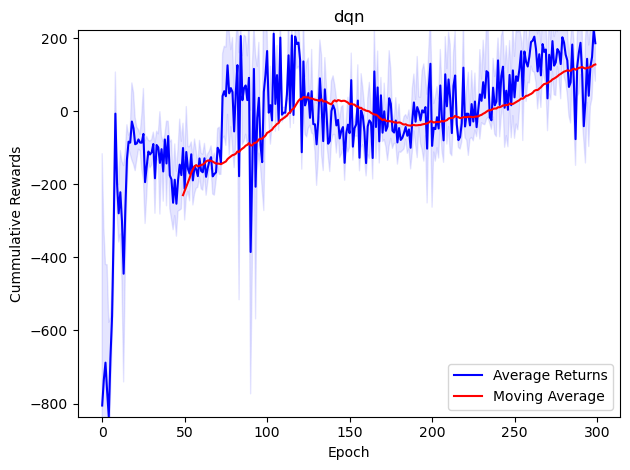

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
plot_returns(
    mean_returns, std_returns, method_name='dqn'
)

MovieWriter imagemagick unavailable; using Pillow instead.


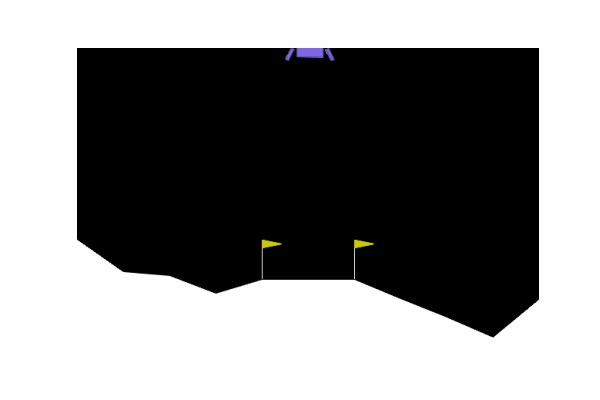

In [6]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='dqn')
Image(open(gif_path,'rb').read())

## 4. BLIP-2 (VLM) as a Reward Modifier of DQN & Plotting Results

In [7]:
from src.VLMdqn import train_one_epoch as VLMdqn_epoch

# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    
    # copy target network params
    target_Q.load_state_dict(Q.state_dict())

    VLMdqn_epoch(
        env=environment, Q=Q, target_Q=target_Q,
        memory=memory, optimizer=optimizer
    )
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    from src.VLMdqn import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')
    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='Vision-DQN', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

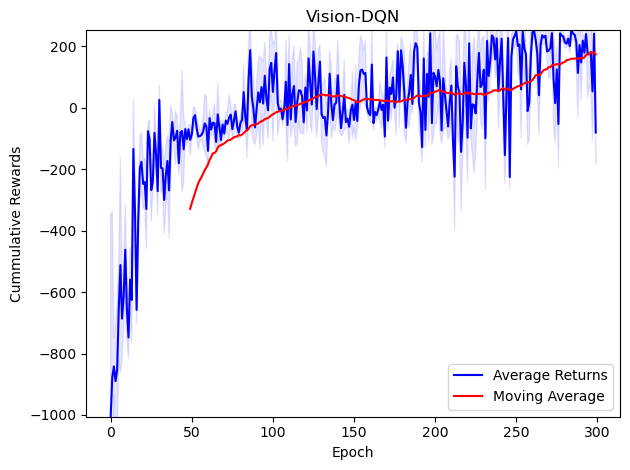

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
plot_returns(mean_returns, std_returns, method_name='Vision-DQN')

MovieWriter imagemagick unavailable; using Pillow instead.


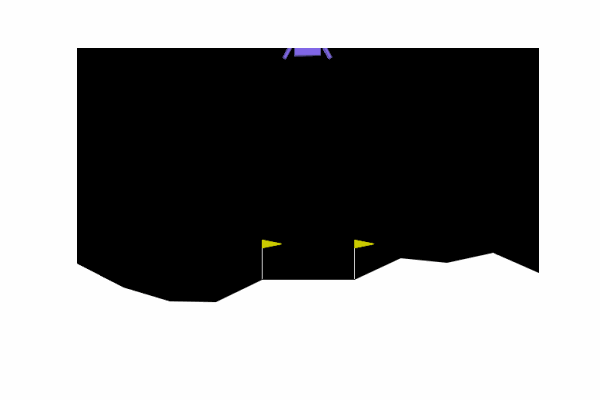

In [9]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='Vision-DQN')
Image(open(gif_path,'rb').read())